1. PROJECT NAME- TESLA STOCK PRICE PREDICTION.

2. PROJECT SUMMARY-

    This project aims to predict Tesla’s stock price using deep learning time-series models, specifically SimpleRNN and LSTM. Historical stock data was cleaned, analyzed through EDA, and the Adjusted Close price was selected as the target variable. After scaling the data and creating time-series sequences with a 60-day lookback window, models were trained to predict 1-day, 5-day, and 10-day price horizons.

    Model performance was evaluated using MSE and MAE, where LSTM demonstrated superior performance across most horizons, especially for medium-term forecasting. All models and preprocessing artifacts were saved and deployed using Streamlit in a fully inference-based setup, allowing users to explore stock analytics and generate future price predictions without retraining the models.

3. PROBLEM STATEMENT-

    The objective of this project is to predict Tesla’s stock closing price using historical stock price data. Since stock prices are sequential and time-dependent, deep learning models such as SimpleRNN and LSTM are used to capture temporal dependencies. The models will predict the closing price for 1-day, 5-day, and 10-day horizons.

4. DATA WRANGLING-

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# To prevent truncating
pd.set_option('display.max_columns', None)

# Reading the file and creating a dataframe of it
df = pd.read_csv('../data/TSLA.csv')

# To check the first 5 rows of the dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29-06-10,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,30-06-10,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,01-07-10,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,02-07-10,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,06-07-10,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
# Check for null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Checking the info of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB
None


In [6]:
# Checking the description of the dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [7]:
# Checking for full-row duplicates
df.duplicated().sum()

0

In [8]:
# Checking for date duplicates
df['Date'].duplicated().sum()

0

In [9]:
# Checking the shape of the dataset
print(df.shape)
print(df.columns.to_list())

(2416, 7)
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [10]:
# Date conversion
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)    # The date is converted to this format -> YYYY-MM-DD 

# Sorting using Date Column
df = df.sort_values('Date')                               # Sorting the dataset chronologically

# Using the date column as index
df.set_index('Date', inplace=True)

In [11]:
# Checking the first few rows
df.head(7)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700
2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400


In [12]:
# Checking the last few rows
df.tail(7)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-24,570.630005,573.859985,554.260010,564.820007,564.820007,14353600
2020-01-27,541.989990,564.440002,539.280029,558.020020,558.020020,13608100
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


5. Exploratory Data Analysis- We'll be wrapping each graph under a function so that it can be reused later when displaying the analytics in the streamlit dashboard.

I. Plotting a graph that shows the adjusted closing price over the years.

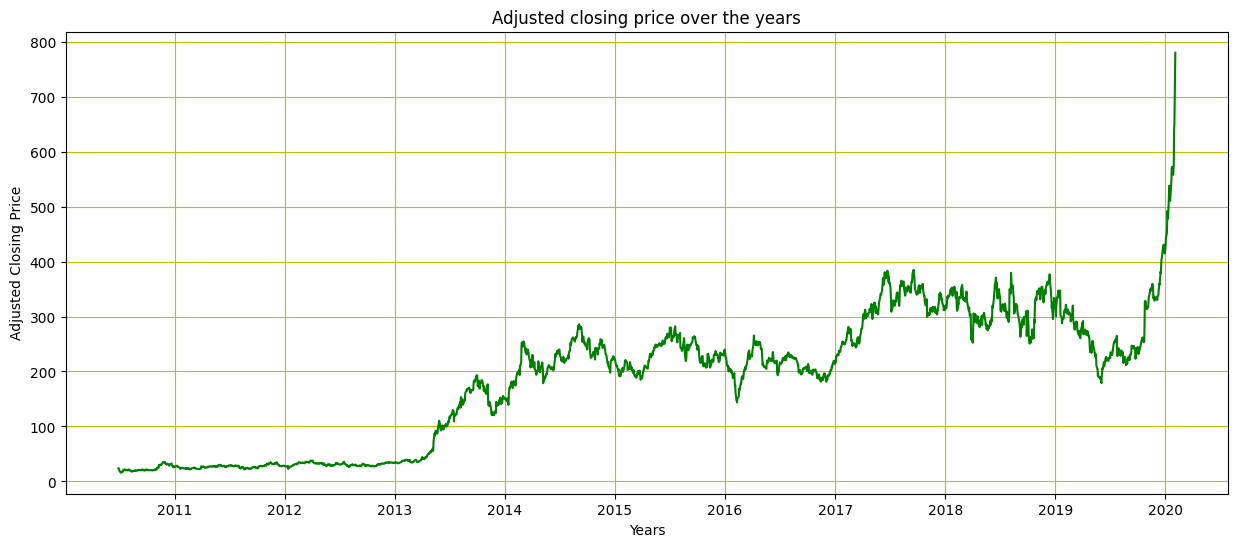

In [13]:
def plot_adj_close(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index, df['Adj Close'], color='green')
    ax.set_title('Adjusted closing price over the years')
    ax.grid(color='y')
    ax.set_ylabel('Adjusted Closing Price')
    ax.set_xlabel('Years')
    return fig

fig = plot_adj_close(df)
plt.show()

Insights-
- The Adjusted closing prices denotes the last traded price (LTP) after corporate actions like splits, dividend and bonus shares.
- From the above graph, we can see that there's a dip in the adjusted LTP in the first few months of 2016, but recovered shortly within few months.
- From 2019 to 2020, we can see a "W-pattern" which denotes that there will be an increase in the adjusted LTP in the upcoming years.

II. Plotting a graph that shows the opening price over the years.

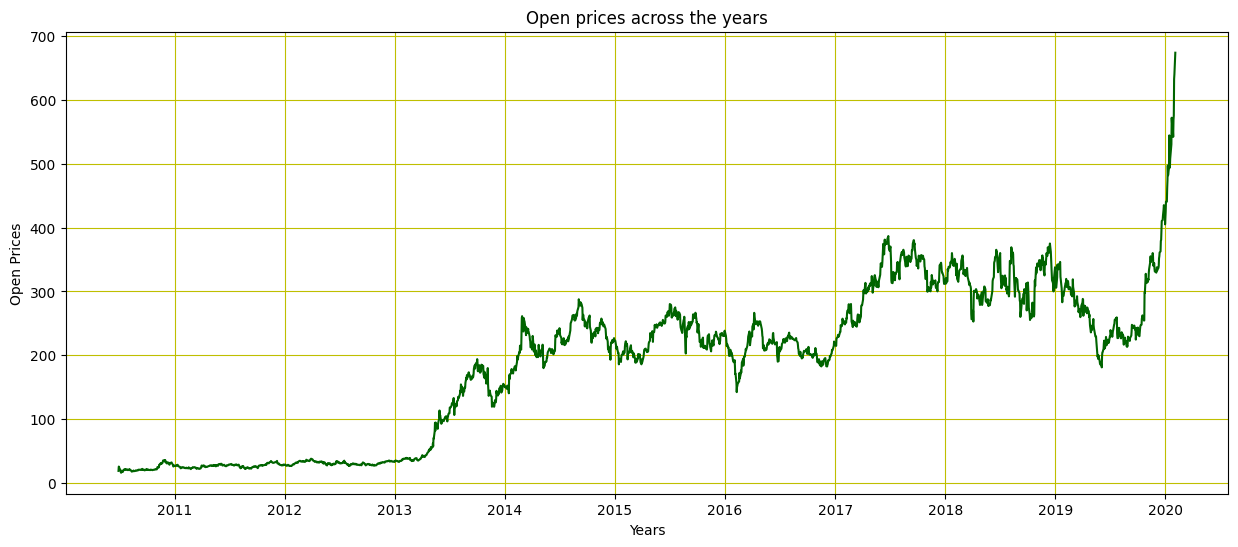

In [14]:
def plot_open(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index,df['Open'],color='darkgreen')
    ax.set_title('Open prices across the years')
    ax.set_xlabel('Years')
    ax.set_ylabel('Open Prices')
    ax.grid(color='y')
    return fig

fig = plot_open(df)
plt.show()

Insights-
- Open prices denote the price of the first transaction after the market's opening time. It is not the the as the previous day's adjusted closing price.
- From the above graph, we can see that the trend is very similar to that of the adjusted closing price graph, with the similar patterns forming at the same intervals.

III. Visualising the volume of stocks traded over the years.

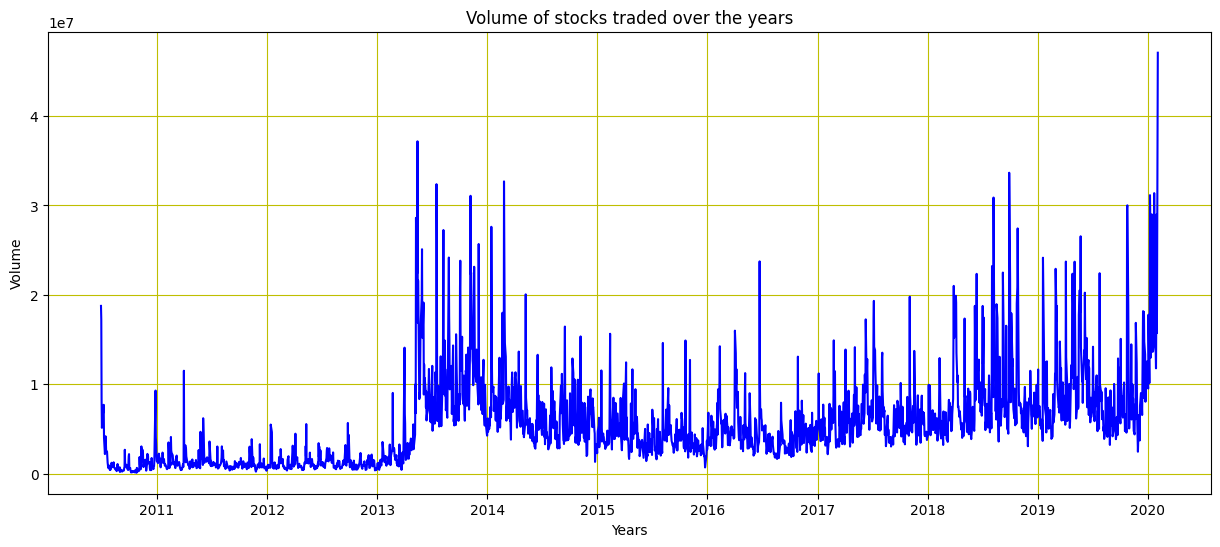

In [15]:
def plot_vol(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index,df['Volume'],color='blue')
    ax.set_title('Volume of stocks traded over the years')
    ax.set_xlabel('Years')
    ax.set_ylabel('Volume')
    ax.grid(color='y')
    return fig

fig = plot_vol(df)
plt.show()

Insights-
- Volume denotes the number of stocks traded.
- From the above graph, we can see that the volume of stocks traded from 2013-2014 has been the highest in the 2010s decade; the end of 2018 also shows a high volume of stocks traded.
- We can see that the first few months of 2020 saw an even higher number of shares traded as compared to the 2013-2014 spike. It is during this time when the LTP of the stock increases significantly.

IV. Visualising the highs and lows of the stock over the years.

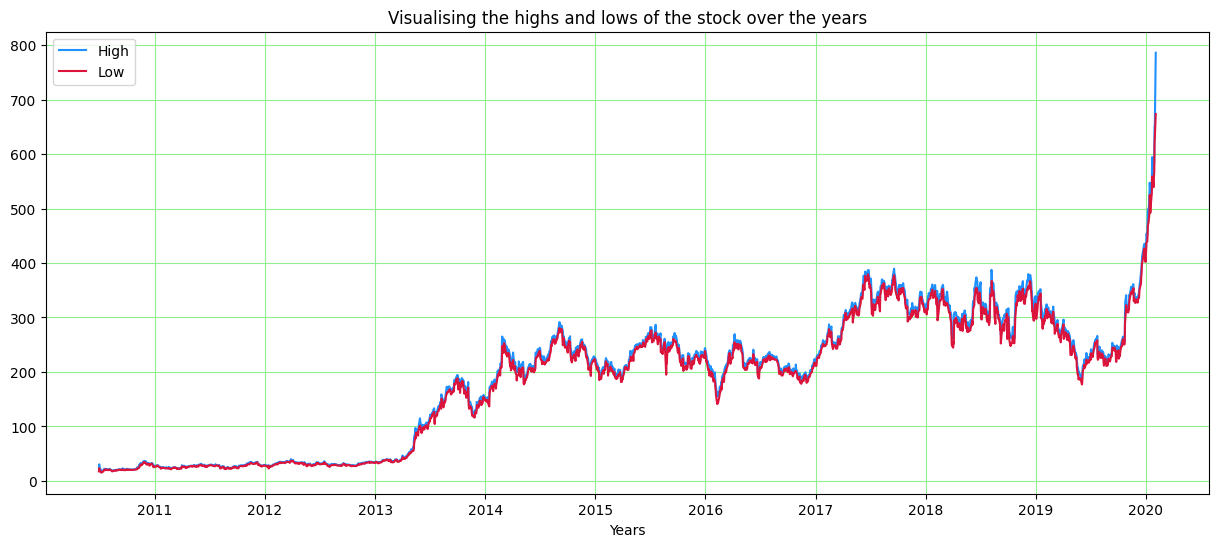

In [16]:
def plot_high_low(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index,df['High'],color='dodgerblue',label='High')
    ax.plot(df.index,df['Low'],color='crimson',label='Low')
    ax.set_title('Visualising the highs and lows of the stock over the years')
    ax.grid(color='lightgreen')
    ax.set_xlabel('Years')
    ax.legend()
    return fig

fig = plot_high_low(df)
plt.show()

Insights-
- The High price denotes the highest price at which the stock was traded on a particular trading day, while the Low price denotes the same but for the lowest price at which it was traded.
- The trend remains similar to the adjusted closing and opening prices, showing an upward trend and forming similar patterns at same intervals.
- The difference between the high and low price keep increasing over time indicating higher volatility, suggesting higher investor participation.

V. Visualising Open and Adjusted Close overlay- Helps us check price consistency within a day and identifies abnormal spread or data issues.

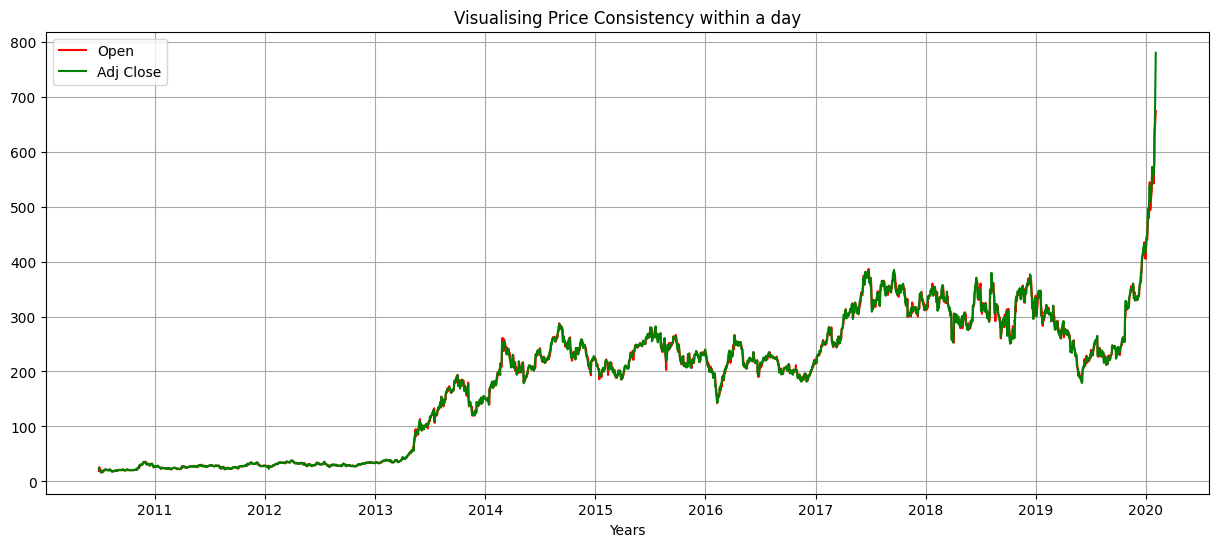

In [17]:
def plot_overlay(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index, df['Open'], color='red', label='Open')
    ax.plot(df.index, df['Adj Close'], color='green', label='Adj Close')
    ax.set_title('Visualising Price Consistency within a day')
    ax.set_xlabel('Years')
    ax.grid(color='darkgray')
    ax.legend()
    return fig

fig = plot_overlay(df)
plt.show()

Insights-
- Across the graph we can see that the opening and closing prices are nearly overlapping suggesting modest daily returns.
- Towards the end of 2019 and the beginning of 2020, we can see the graph grows steeper and the gap between opening and closing increasing indicating strong bullish sentiment.

VI. Visualising relationship between price levels and trading activity.

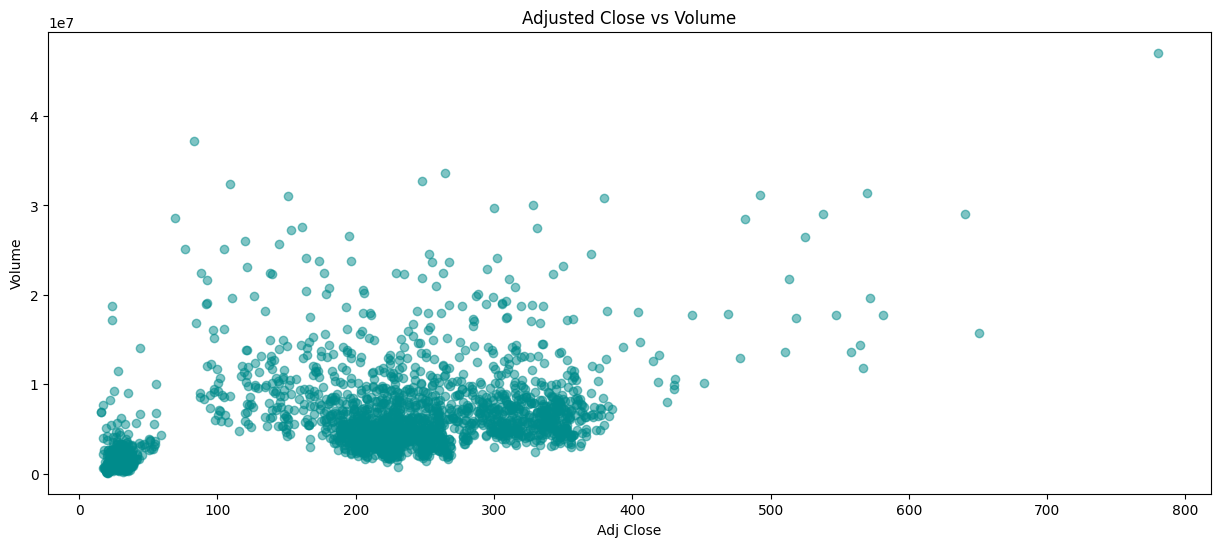

In [18]:
def plot_clo_vol(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.scatter(df['Adj Close'], df['Volume'],color='darkcyan', alpha=0.5)
    ax.set_title('Adjusted Close vs Volume')
    ax.set_xlabel('Adj Close')
    ax.set_ylabel('Volume')
    return fig

fig = plot_clo_vol(df)
plt.show()

Insights-
- The above graph shows that there is no strong or direct linear relationship with higher or lower closing price.
- High volume observations can be seen during price changes rather than at stable price levels, indicating increase in investor activities during momentum shifts.

VII. Visualising Daily Price Changes.

In [19]:
# Making a new feature showing the difference in price in a day
df['price_change'] = df['Adj Close'] - df['Open']

# Checking the first few rows of the ipdated dataframe
df.head()

,Open,High,Low,Close,Adj Close,Volume,price_change
Date,,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,4.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,-1.960001
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,-3.040001
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,-3.799999
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,-3.889999


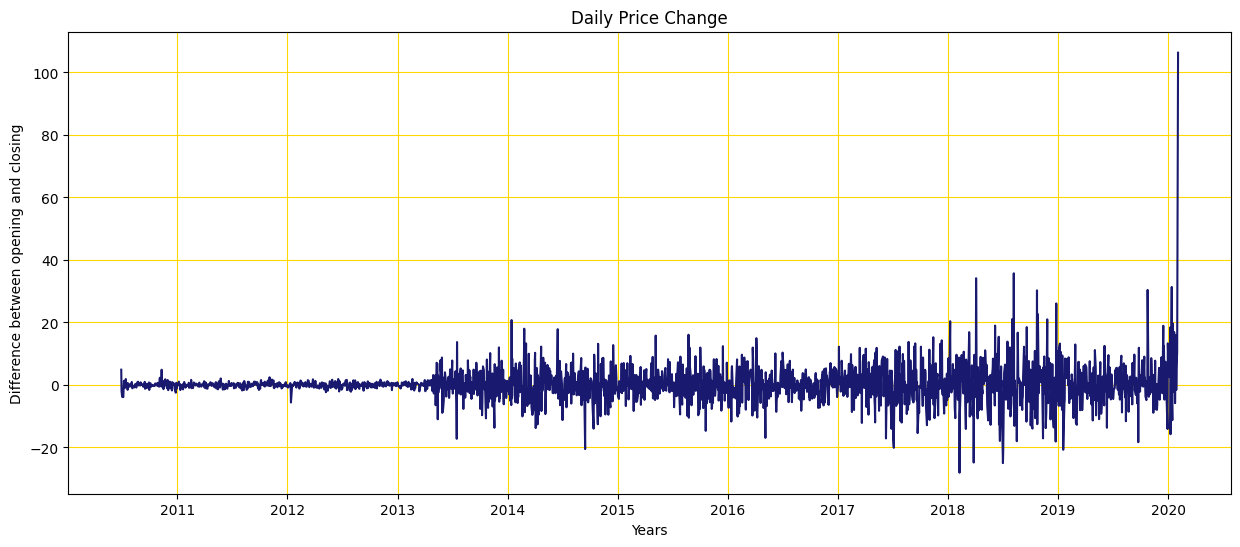

In [20]:
# Plotting the graph to visualise these price changes
def plot_price_change(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index, df['price_change'], color='midnightblue')
    ax.set_title('Daily Price Change')
    ax.set_xlabel('Years')
    ax.set_ylabel('Difference between opening and closing')
    ax.grid(color='gold')
    return fig

fig = plot_price_change(df)
plt.show()

Insights-
- The negative values denote that the closing price for those days were lower than the opening price, which indicates Bearish days.
- The positive values denote that the closing price for those days were higher that the opening price which indicates Bullish days.

VIII. Visualising Daily Returns.

In [21]:
# Creating a new feature named daily_returns
df['daily_returns'] = df['Adj Close'].pct_change()

# Checking the first few rows of the updated dataframe
df.head()

,Open,High,Low,Close,Adj Close,Volume,price_change,daily_returns
Date,,,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,4.889999,NaN
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,-1.960001,-0.002511
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,-3.040001,-0.078473
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,-3.799999,-0.125683
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,-3.889999,-0.160937


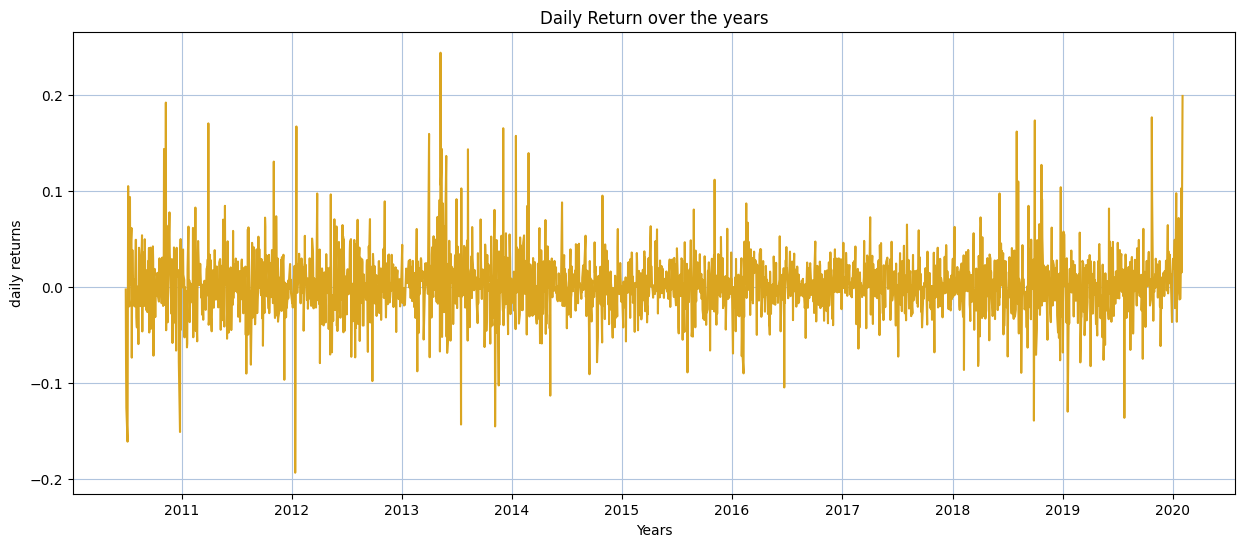

In [22]:
# Plotting the graph
def plot_daily_returns(df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df.index, df['daily_returns'], color='goldenrod')
    ax.set_title('Daily Return over the years')
    ax.set_xlabel('Years')
    ax.set_ylabel('daily returns')
    ax.grid(color='lightsteelblue')
    return fig

fig= plot_daily_returns(df)
plt.show()

Insights-
- From the above graph, we see that there is no obvious long-term trend in the daily returns.
- The overall spread of returns look fairly stable over time.
- Most daily returns are tightly clustered around 0, with occasional spikes indicating jumps or crashes in the market due to certain news or events affecting the sentiment of the investors.

6. Feature Selection- Creating a new dataframe that contains only the selected features that will go into the model.

In [23]:
# Creating a new dataframe
df_model = df[['Adj Close','Volume']]

# Checking the first few rows of the dataframe
df_model.head()

,Adj Close,Volume
Date,,
2010-06-29,23.889999,18766300
2010-06-30,23.830000,17187100
2010-07-01,21.959999,8218800
2010-07-02,19.200001,5139800
2010-07-06,16.110001,6866900


7. Creating train, validation and test splits explicitly to preserve temporal order.

In [24]:
# Storing the length of the dataframe in a variable
n = len(df_model)

# Calculating the training set endpoint at 70% of the total data
train_size = int(n * 0.70)

# Calculating the validation set endpoint at 85% cumulative (15% after training)
val_size = int(n * 0.85)

# Creating the training split
train_df = df_model.iloc[:train_size]

# Creating the validation split
val_df = df_model.iloc[train_size:val_size]

# Creating the test split
test_df = df_model.iloc[val_size:]

In [25]:
# Showing first and last index of training set
print('Train:\n',train_df.index.min(), 'to', train_df.index.max())

# Showing first and last index of validation set
print('Validation:\n',val_df.index.min(), 'to', val_df.index.max())

# Showing first and last index of test set
print('Test:\n',test_df.index.min(), 'to', test_df.index.max())

Train:
 2010-06-29 00:00:00 to 2017-03-16 00:00:00
Validation:
 2017-03-17 00:00:00 to 2018-08-22 00:00:00
Test:
 2018-08-23 00:00:00 to 2020-02-03 00:00:00


8. Applying MinMaxScaler to normalize features between 0 and 1.

In [26]:
# Importing the scaler
from sklearn.preprocessing import MinMaxScaler

# Initialising the scaler
scaler = MinMaxScaler()

# Fitting the scaler on only the training data and then transforming all splits using the same scaler
## train_scaled, val_scaled, test_scaled are numpy arrays
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [27]:
# Checking the length of each of the dataset
print(len(train_scaled), len(val_scaled), len(test_scaled))

1691 362 363


9. Time-Series Sequence Creation- We will create separate training, validation and testing datasets for 1-day, 5-day and 10-day horizon with a lookback window of 60 days.

In [28]:
# Defining a function that creates input-output sequence pairs for LSTM and SimpleRNN models.
def create_sequences(data, lookback, horizon):
    x, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        # Append input sequence
        x.append(data[i:i + lookback])                      # Creates on input window per iteration

        # Append target value
        y.append(data[i + lookback + horizon - 1, 0])       # Pairs each input sequence with single target value
        
    # Return converted arrays
    return np.array(x), np.array(y)

In [29]:
# Setting the look back window to 60
lookback = 60

In [30]:
# Creating the datasets for 1-day horizon
x_train_1s, y_train_1s = create_sequences(train_scaled, lookback, horizon=1)
x_val_1s, y_val_1s = create_sequences(val_scaled, lookback, horizon=1)
x_test_1s, y_test_1s = create_sequences(test_scaled, lookback, horizon=1)

In [31]:
# Checking the shape for the three datasets of 1-day horizon
print('Training:\n',x_train_1s.shape, y_train_1s.shape)
print('Validation:\n',x_val_1s.shape, y_val_1s.shape)
print('Testing:\n',x_test_1s.shape, y_test_1s.shape)

Training:
 (1631, 60, 2) (1631,)
Validation:
 (302, 60, 2) (302,)
Testing:
 (303, 60, 2) (303,)


In [32]:
# Creating the datasets for 5-day horizon
x_train_5s, y_train_5s = create_sequences(train_scaled, lookback, horizon=5)
x_val_5s, y_val_5s = create_sequences(val_scaled, lookback, horizon=5)
x_test_5s, y_test_5s = create_sequences(test_scaled, lookback, horizon=5)

In [33]:
# Checking the shape for the three datasets of 5-day horizon
print('Training:\n',x_train_5s[0].shape, y_train_5s.shape)
print('Validation:\n',x_val_5s[0].shape, y_val_5s.shape)
print('Testing:\n',x_test_5s[0].shape, y_test_5s.shape)

Training:
 (60, 2) (1627,)
Validation:
 (60, 2) (298,)
Testing:
 (60, 2) (299,)


In [34]:
# Creating the datasets for 10-day horizon
x_train_10s, y_train_10s = create_sequences(train_scaled, lookback, horizon=10)
x_val_10s, y_val_10s = create_sequences(val_scaled, lookback, horizon=10)
x_test_10s, y_test_10s = create_sequences(test_scaled, lookback, horizon=10)

In [35]:
# Checking the shape for the three datasets of 10-day horizon
print('Training:\n',x_train_10s[0].shape, y_train_10s.shape)
print('Validation:\n',x_val_10s[0].shape, y_val_10s.shape)
print('Testing:\n',x_test_10s[0].shape, y_test_10s.shape)

Training:
 (60, 2) (1622,)
Validation:
 (60, 2) (293,)
Testing:
 (60, 2) (294,)


10. Defining a function to build the SimpleRNN model.

In [36]:
# Importing the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN

In [37]:
def build_simplernn(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))        # SimpleRNN layer
    model.add(Dropout(dropout_rate))                            # Dropout layer -> drops a certain fraction of inputs, reduces overfitting
    model.add(Dense(1))                                         # Output layer with one neuron, good for continuous output and regression tasks
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

11. Training the model and generating predictions for 1-day horizon.

In [38]:
# Building the model
input_shape_1 = (x_train_1s.shape[1], x_train_1s.shape[2])
rnn_1day = build_simplernn(input_shape_1)

# Training the model
history_1day = rnn_1day.fit(x_train_1s, y_train_1s,
                            epochs=20, batch_size=32,
                            validation_data=(x_val_1s, y_val_1s), verbose=1)

# Evaluation
test_loss_1day, test_mae_1day = rnn_1day.evaluate(x_test_1s, y_test_1s)
print('\nTest MSE for 1-day:', test_loss_1day)
print('Test MAE for 1-day:', test_mae_1day)

Epoch 1/20
51/51 [==============================] - 5s 37ms/step - loss: 0.0818 - mae: 0.1792 - val_loss: 0.0297 - val_mae: 0.1592
Epoch 2/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0144 - mae: 0.0832 - val_loss: 0.0200 - val_mae: 0.1284
Epoch 3/20
51/51 [==============================] - 1s 22ms/step - loss: 0.0097 - mae: 0.0688 - val_loss: 0.0206 - val_mae: 0.1315
Epoch 4/20
51/51 [==============================] - 1s 23ms/step - loss: 0.0080 - mae: 0.0612 - val_loss: 0.0120 - val_mae: 0.0960
Epoch 5/20
51/51 [==============================] - 1s 23ms/step - loss: 0.0057 - mae: 0.0534 - val_loss: 0.0184 - val_mae: 0.1248
Epoch 6/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0525 - val_loss: 0.0106 - val_mae: 0.0903
Epoch 7/20
51/51 [==============================] - 1s 22ms/step - loss: 0.0054 - mae: 0.0507 - val_loss: 0.0100 - val_mae: 0.0882
Epoch 8/20
51/51 [==============================] - 1s 22ms/step - loss: 0.0049 - m

In [39]:
# Generating predictions on test set for 1-day
y_pred_1_scaled = rnn_1day.predict(x_test_1s)

10/10 [==============================] - 1s 12ms/step


In [40]:
# Defining an inverse transform helper
def inverse_transform_adj_close(scaled_values, scaler, n_features=2, target_col=0):
    dummy = np.zeros((len(scaled_values), n_features))              # Creates fake data of only zeros that matches training shape
    dummy[:,target_col] = scaled_values.reshape(-1)                 # Put real predictions in target column, leaving others as 0
    return scaler.inverse_transform(dummy)[:,target_col]            # Gives back original-scale predictions

In [41]:
# Inverse tranform predictions for 1-day
y_pred_1 = inverse_transform_adj_close(y_pred_1_scaled, scaler)

# Inverse transform actual test values
y_test_1 = inverse_transform_adj_close(y_test_1s, scaler)

# Checking the values after inverse transform
print(y_pred_1[:5])
print(y_test_1[:5])

[330.16583132 333.42097585 331.62333997 329.34408805 325.41915897]
[354.309998 353.470001 347.48999  338.190002 325.829987]


---------- For 1-day horizon ----------


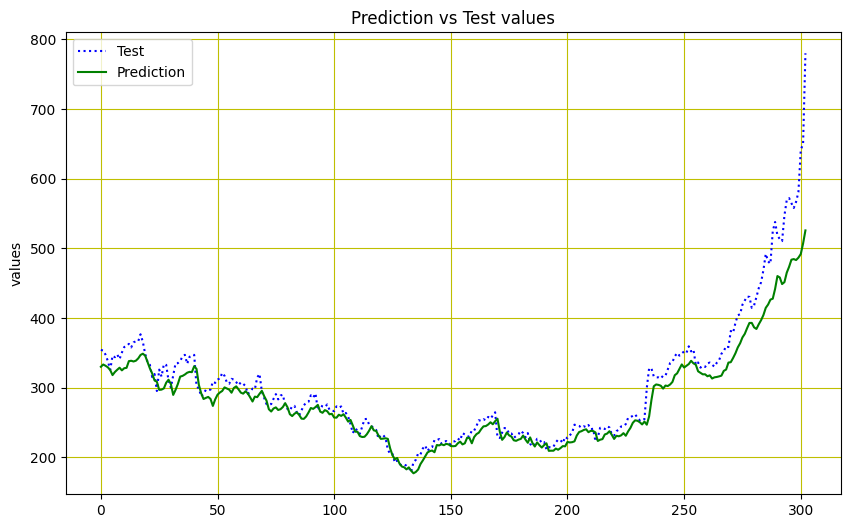

In [42]:
# Plotting the graph between actual test values and predictions
## Defining a helper that can be reused to plot predictions vs actual test values graph for SimpleRNN
def plot_test_pred(y_pred, y_test):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(range(len(y_test)), y_test, color='blue', linestyle='dotted', label='Test')
    ax.plot(range(len(y_pred)), y_pred, color='green', label='Prediction')
    ax.set_title('Prediction vs Test values')
    ax.set_ylabel('values')
    ax.legend()
    ax.grid(color='y')
    return fig

print('---------- For 1-day horizon ----------')
fig = plot_test_pred(y_pred_1, y_test_1)
plt.show()

Insights-

The graph above shows that SimpleRNN was able to capture short-term price movement but struggled during periods of high volatility and trend shifts due to its limited memory.

12. Training the model and generating predictions for 5-day horizon.

In [43]:
# Building the model
input_shape_5 = (x_train_5s.shape[1], x_train_5s.shape[2])
rnn_5day = build_simplernn(input_shape_5)

# Training the model
history_5day = rnn_5day.fit(x_train_5s, y_train_5s,
                            epochs=20, batch_size=32,
                            validation_data=(x_val_5s, y_val_5s), verbose=1)

# Evaluation
test_loss_5day, test_mae_5day = rnn_5day.evaluate(x_test_5s, y_test_5s)
print('\nTest MSE for 5-day:', test_loss_5day)
print('Test MAE for 5-day:', test_mae_5day)

Epoch 1/20
51/51 [==============================] - 4s 33ms/step - loss: 0.2152 - mae: 0.2582 - val_loss: 0.0804 - val_mae: 0.2644
Epoch 2/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0220 - mae: 0.1047 - val_loss: 0.0502 - val_mae: 0.2020
Epoch 3/20
51/51 [==============================] - 1s 25ms/step - loss: 0.0175 - mae: 0.0940 - val_loss: 0.0333 - val_mae: 0.1584
Epoch 4/20
51/51 [==============================] - 1s 25ms/step - loss: 0.0155 - mae: 0.0884 - val_loss: 0.0525 - val_mae: 0.2096
Epoch 5/20
51/51 [==============================] - 1s 26ms/step - loss: 0.0132 - mae: 0.0808 - val_loss: 0.0457 - val_mae: 0.1929
Epoch 6/20
51/51 [==============================] - 1s 23ms/step - loss: 0.0112 - mae: 0.0740 - val_loss: 0.0383 - val_mae: 0.1738
Epoch 7/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0103 - mae: 0.0720 - val_loss: 0.0346 - val_mae: 0.1632
Epoch 8/20
51/51 [==============================] - 1s 23ms/step - loss: 0.0080 - m

In [44]:
# Generating predictions on test set for 5-days
y_pred_5_scaled = rnn_5day.predict(x_test_5s)

10/10 [==============================] - 0s 11ms/step


In [45]:
# Inverse tranform predictions for 5-days
y_pred_5 = inverse_transform_adj_close(y_pred_5_scaled, scaler)

# Inverse transform actual test values
y_test_5 = inverse_transform_adj_close(y_test_5s, scaler)

# Checking the values after inverse transform
print(y_pred_5[:5])
print(y_test_5[:5])

[308.37220634 307.51679827 310.20382918 316.4168049  314.59938894]
[325.829987 346.       343.920013 347.869995 341.170013]


--------- For 5-day horizon ---------


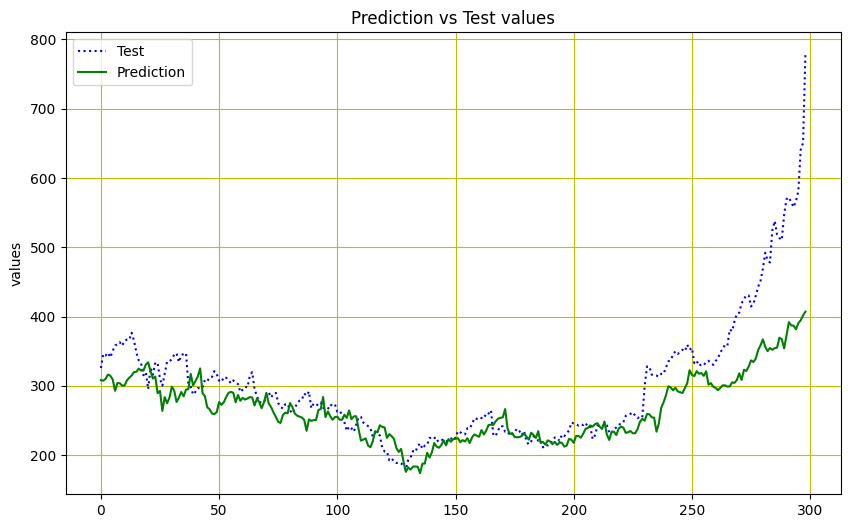

In [46]:
# Plotting the graph between predicted results and actual test values using the previously defined helper
print('--------- For 5-day horizon ---------')
plot_test_pred(y_pred_5, y_test_5)
plt.show()

Insights-

From the above graph, we see that for 5-day prediction, the model captures the overall trend but with increased lag and smoothing compared to the 1-day forecast.

13. Training the model and generating predictions for 10-day horizon.

In [47]:
# Building the model
input_shape_10 = (x_train_10s.shape[1], x_train_10s.shape[2])
rnn_10day = build_simplernn(input_shape_10)

# Training the model
history_10day = rnn_10day.fit(x_train_10s, y_train_10s,
                              epochs=20, batch_size=32,
                              validation_data=(x_val_10s, y_val_10s), verbose=1)

# Evaluation
test_loss_10day, test_mae_10day = rnn_10day.evaluate(x_test_10s, y_test_10s)
print('\nTest MSE for 10-day:', test_loss_10day)
print('Test MAE for 10-day:', test_mae_10day)

Epoch 1/20
51/51 [==============================] - 4s 33ms/step - loss: 0.0364 - mae: 0.1224 - val_loss: 0.0100 - val_mae: 0.0777
Epoch 2/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0124 - mae: 0.0797 - val_loss: 0.0282 - val_mae: 0.1460
Epoch 3/20
51/51 [==============================] - 1s 25ms/step - loss: 0.0104 - mae: 0.0712 - val_loss: 0.0279 - val_mae: 0.1446
Epoch 4/20
51/51 [==============================] - 1s 23ms/step - loss: 0.0087 - mae: 0.0660 - val_loss: 0.0396 - val_mae: 0.1787
Epoch 5/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0627 - val_loss: 0.0213 - val_mae: 0.1214
Epoch 6/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0580 - val_loss: 0.0272 - val_mae: 0.1423
Epoch 7/20
51/51 [==============================] - 1s 22ms/step - loss: 0.0070 - mae: 0.0594 - val_loss: 0.0230 - val_mae: 0.1283
Epoch 8/20
51/51 [==============================] - 1s 24ms/step - loss: 0.0067 - m

In [48]:
# Generating predictions on test set for 10-days
y_pred_10_scaled = rnn_10day.predict(x_test_10s)

10/10 [==============================] - 0s 12ms/step


In [49]:
# Inverse tranform predictions for 10-days
y_pred_10 = inverse_transform_adj_close(y_pred_10_scaled, scaler)

# Inverse transform actual test values
y_test_10 = inverse_transform_adj_close(y_test_10s, scaler)

# Checking the values after inverse transform
print(y_test_10[:5])
print(y_pred_10[:5])

[350.480011 358.48999  359.700012 363.059998 357.970001]
[315.26057205 316.9381744  325.23559722 324.17230498 318.69112791]


------------- For 10-day horizon -------------


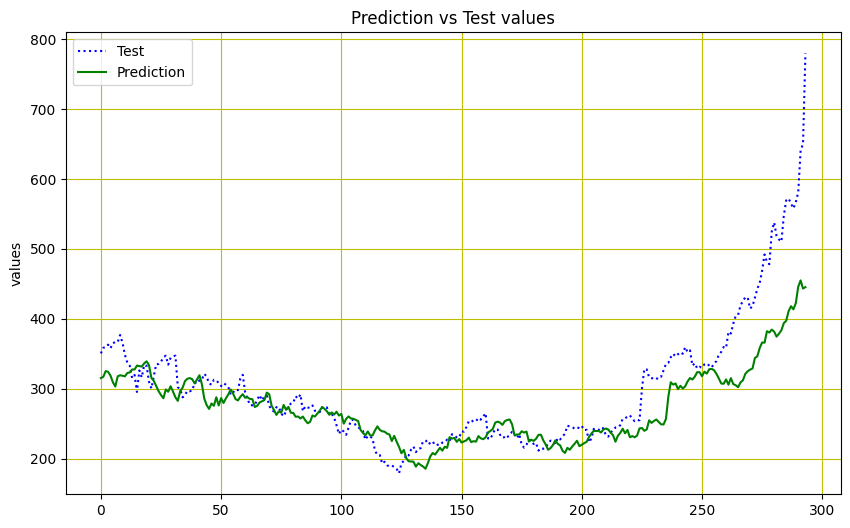

In [50]:
# Plotting the graph between predicted results and actual test values using the previously defined helper
print('------------- For 10-day horizon -------------')
plot_test_pred(y_pred_10, y_test_10)
plt.show()

Insights-

As the prediction horizon increases, we see that the model captures the the overall trend while exhibiting increased lag and smoothing effects. It's ability to predict sudden changes deteriorates significantly at longer horizons.

14. Saving the necessary artifacts such as scaler, metadata, trained SimpleRNN model and scaled data.

In [51]:
# Importing the libraries that will help to save the artifacts
import os
import joblib

In [52]:
# Creating artifacts directory
artifact_dir = '../data/artifacts'
os.makedirs(artifact_dir, exist_ok=True)

# Saving the dataframes
joblib.dump(df, os.path.join(artifact_dir, 'df.joblib'))
joblib.dump(df_model, os.path.join(artifact_dir, 'df_model.joblib'))

# Saving fitted MinMaxScaler
joblib.dump(scaler, os.path.join(artifact_dir, 'scaler.joblib'))

# Saving scaled train/val/test splits
joblib.dump(train_scaled, os.path.join(artifact_dir, 'train_scaled.joblib'))
joblib.dump(val_scaled, os.path.join(artifact_dir, 'val_scaled.joblib'))
joblib.dump(test_scaled, os.path.join(artifact_dir, 'test_scaled.jolib'))

# Saving the trained SimpleRNN models for 1-day, 5-day and 10-day horizon
os.makedirs('../data/models/simplernn', exist_ok=True)
rnn_1day.save('../data/models/simplernn/rnn_1day.h5')
rnn_5day.save('../data/models/simplernn/rnn_5day.h5')
rnn_10day.save('../data/models/simplernn/rnn_10day.h5')

# Saving the metadata
metadata = {
    'model_name':'SimpleRNN',
    'features':['Adj Close','Volume'],
    'target':'Adj Close',
    'lookback':lookback,
    'horizons':[1,5,10]
}

joblib.dump(metadata, os.path.join(artifact_dir, 'metadata.joblib'))

print('Artifacts saved')

Artifacts saved
